## S&P Global - CORE2LOG: AUTOMATIC ROCK CLASSIFICATION
### Misael M. Morales, Oriyomi Raheem, Carlos Torres-Verdin, and Michael Pyrcz, UT-Austin; Murray Christie, Vladimir Rabinovich, S&P Global
#### 2024, Digital Reservoir Characterization Technology (DiReCT)
***

In [ ]:
from auto_rock_classification import *

In [ ]:
# RUN PROCESSING
# this module will load the Core data for all wells, and do:
# (1) filter the wells based on the minimum number of core points specified
# (2) apply a clustering technique to estimate the rock classes along the well
# (3) save the results of the predicted classes in a csv file for all wells
RockClassification(minpts=30, method='gmm', n_classes=3).run_processing()

In [ ]:
# RUN DASHBOARD
# this module will load the Core2Log Rock Classification dashboard:
# (1) specify the well to analyze
# (2) specify the rock classification technique to use
#   (2a) if the technique is physics-based: specify cutoffs
#   (2b) if the technique is ML-based: specify the number of classes
# (3) run the dashboard to visualize results
RockClassification(minpts=30, well_number=1104, method='birch', n_classes=3).run_dashboard(maketitle=False)

In [ ]:
# COMPARISON
# compare all techniques for a given well (user must define cutoffs and n_classes accordingly)
RockClassification(minpts=30, well_number=1104).run_comparison(n_classes=3, 
                                                    leverett_cutoffs=[10,20,40], 
                                                    winland_cutoffs=[150,300,500], 
                                                    lorenz_cutoffs=[0.5,2,5])

In [ ]:
# SPATIAL DISTRIBUTION
# visualize the spatial distribution of sweet spots
RockClassification().run_spatial_map()

***
# END

--------------------------------------------------------------------------------
                       Compare Rock Classification Methods
--------------------------------------------------------------------------------
Number of Classes: 3
Leverett Cutoffs: [10, 20, 40]
Winland Cutoffs: [150, 300, 500]
Lorenz Cutoffs: [0.5, 2, 5]
--------------------------------------------------------------------------------
All data shape: (102797, 88)
Total number of wells: 1379
--------------------------------------------------------------------------------
Well #1104 | UWI: 42702401710000 | LAT: 29.29 | LONG: -88.64
Well shape: (223, 4)
--------------------------------------------------------------------------------


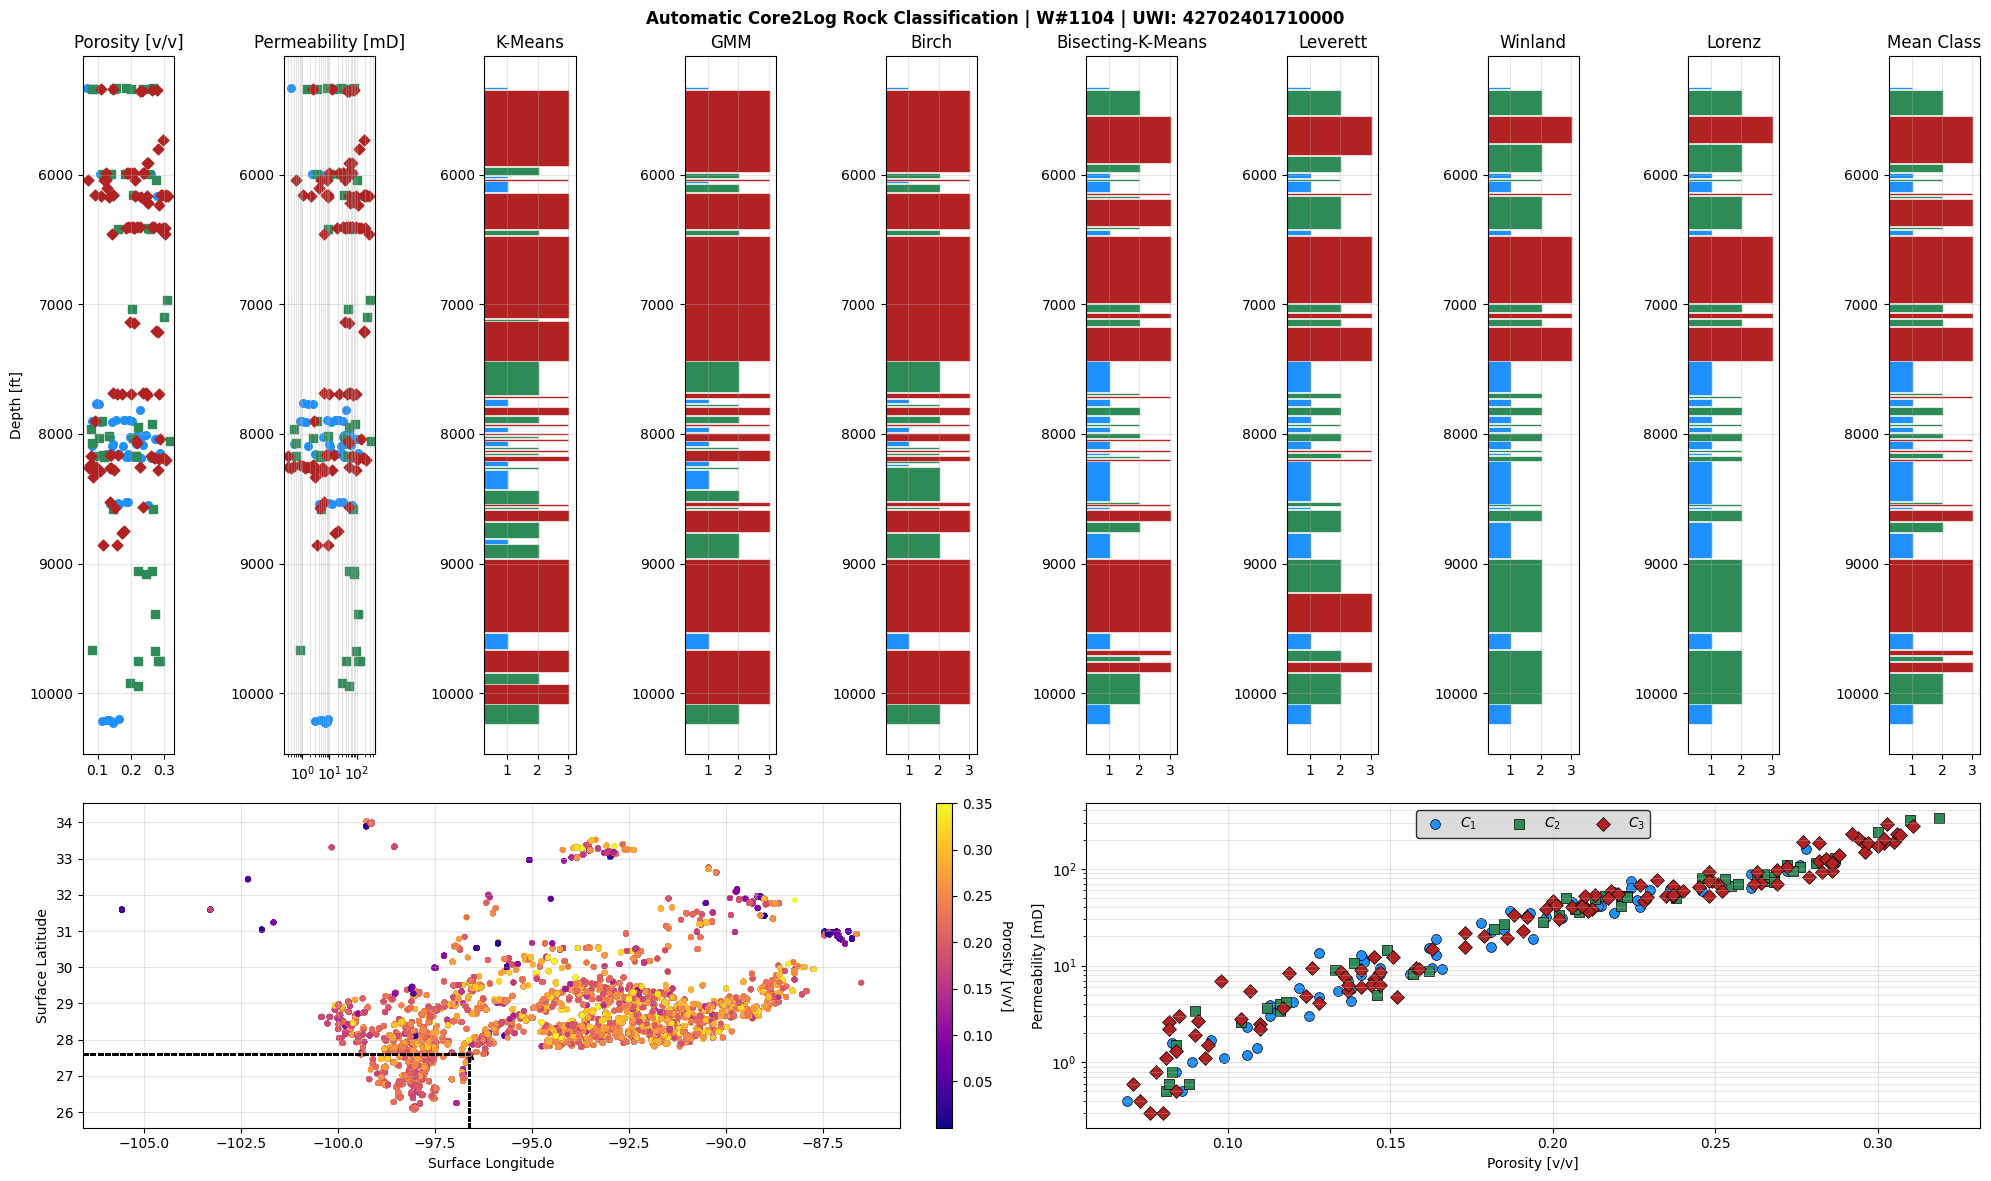

Elapsed time: 10.149 seconds
--------------------------------------------------------------------------------


In [2]:
from auto_rock_classification import *
arc = RockClassification(minpts=30, method='birch', n_classes=3, well_number=1104)
arc.run_comparison(n_classes=3, leverett_cutoffs=[10,20,40], winland_cutoffs=[150,300,500], lorenz_cutoffs=[0.5,2,5])

In [22]:
p, k = arc.d['PORO']/100, arc.d['PERM']
d = pd.DataFrame({'PORO':p, 'PERM':k})

classes = []

clf = make_pipeline(MinMaxScaler(), KMeans(3, random_state=2024)).fit(d)
sc  = np.argsort(clf.steps[-1][1].cluster_centers_.sum(axis=1))
lm  = {sc[i]:i for i in range(3)}
c   = np.array([lm[i] for i in clf.predict(d)])+1
classes.append(c)

clf = make_pipeline(MinMaxScaler(), BisectingKMeans(3, random_state=2024)).fit(d)
sc  = np.argsort(clf.steps[-1][1].cluster_centers_.sum(axis=1))
lm  = {sc[i]:i for i in range(3)}
c   = np.array([lm[i] for i in clf.predict(d)])+1
classes.append(c)

clf = make_pipeline(MinMaxScaler(), GaussianMixture(3, random_state=2024)).fit(d)
sc  = np.argsort(clf.steps[-1][1].means_.sum(axis=1))
lm  = {sc[i]:i for i in range(3)}
c   = np.array([lm[i] for i in clf.predict(d)])+1
classes.append(c)

clf = make_pipeline(MinMaxScaler(), Birch(n_clusters=3, threshold=0.1)).fit(d)
sorted_centroids = np.argsort(clf.steps[-1][1].subcluster_centers_.sum(axis=1))
sublabel_map = {sorted_centroids[i]:i for i in range(len(sorted_centroids))}
subpreds = np.array([sublabel_map[i] for i in clf.predict(d)])
label_map = {label:i for i, label in enumerate(np.unique(subpreds)[::-1])}
c = np.array([label_map[i] for i in subpreds])+1
classes.append(c)

lin_poro = np.linspace(0, .40, 100)

lev_cutoffs = [0,10,20,40]
lev = np.sqrt(k/p)
lev_mask, lev_color_centers = [], []
lev_low, lev_med, lev_high = [], [], []
def leverett_fun(w, l=lin_poro):
    return (w**2 * l)
for i in range(len(lev_cutoffs)-1):
    lev_mask.append(np.logical_and(lev>lev_cutoffs[i], lev<=lev_cutoffs[i+1]))
    lev_color_centers.append(np.mean([lev_cutoffs[i], lev_cutoffs[i+1]]))
for i in range(len(lev_color_centers)):
    lev_low.append(leverett_fun(lev_cutoffs[i]))
    lev_med.append(leverett_fun(lev_color_centers[i]))
    lev_high.append(leverett_fun(lev_cutoffs[i+1]))
for i, m in enumerate(lev_mask):
    d.loc[m,'LEV_CLASS'] = int(i+1)

win_cutoffs = [0,150,300,500]
win = d['PERM']**arc.kexp * 10**arc.texp / d['PORO']**arc.pexp
win_mask, win_color_centers = [], []
win_low, win_med, win_high = [], [], []
def winland_fun(r35, l=lin_poro):
    return ((r35 * l**arc.pexp) / 10**arc.texp) ** (1/arc.kexp)
for i in range(len(win_cutoffs)-1):
    win_mask.append(np.logical_and(win>win_cutoffs[i], win<=win_cutoffs[i+1]))
    win_color_centers.append(np.mean([win_cutoffs[i], win_cutoffs[i+1]]))
for i in range(len(win_color_centers)):
    win_low.append(winland_fun(win_cutoffs[i]))
    win_med.append(winland_fun(win_color_centers[i]))
    win_high.append(winland_fun(win_cutoffs[i+1]))
for i, m in enumerate(win_mask):
    d.loc[m,'WIN_CLASS'] = int(i+1)

lor_cutoffs = [0.5,2,5]
cp = np.cumsum(d['PORO'])/d['PORO'].sum()
ck = np.cumsum(d['PERM'])/d['PERM'].sum()
cv = np.cumsum(np.sort(ck)) / np.cumsum(np.sort(cp)).max()
lor = np.concatenate([[0], np.diff(ck)/np.diff(cp)])
lor_mask = []
ct = [0] + lor_cutoffs
for i in range(len(ct)-1):
    lor_mask.append(np.logical_and(lor>ct[i], lor<=ct[i+1]))
for i, m in enumerate(lor_mask):
    d.loc[m,'LOR_CLASS'] = int(i+1)

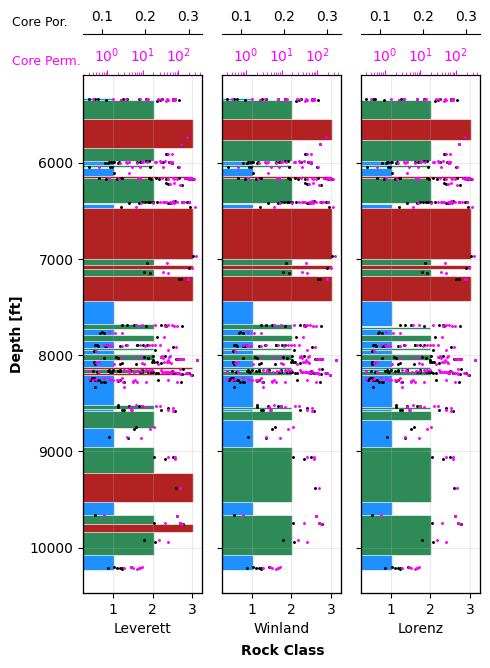

In [27]:
fig, axs = plt.subplots(1, 3, figsize=(5, 6.55), sharey=True)
ax1, ax2, ax3 = axs
labels = ['Leverett', 'Winland', 'Lorenz']
cl_labels = ['LEV_CLASS', 'WIN_CLASS', 'LOR_CLASS']

for i, ax in enumerate(axs):
    z = np.linspace(d.index.min(), d.index.max(), len(d))
    t = np.zeros_like(z)
    class_values = d[cl_labels[i]].values
    for j in range(len(t)):
        t[j] = class_values[np.argmin(np.abs(d.index.values - z[j]))]
        t[j] = t[j-1] if t[j]==0 else t[j]
    for k in range(3):
        ax.fill_betweenx(z, 0, t, where=(t==k+1), color=arc.colors[k])
    ax.set(xlim=(0.25, 3.25), xticks=np.arange(1,4), xticklabels=np.arange(1,4), xlabel=labels[i])
    ax.grid(True, which='both', alpha=0.25)

    axa = ax.twiny()
    axa.scatter(d['PORO'], d.index, color='k', marker='.', s=5)
    axa.spines['top'].set_position(('axes', 1.08))

    axb = ax.twiny()
    axb.scatter(d['PERM'], d.index, color='magenta', marker='.', s=5)
    axb.set(xscale='log')
    axb.xaxis.set_tick_params(color='magenta', labelcolor='magenta', which='both')
    axb.xaxis.set_tick_params(color='magenta')
    axb.spines['top'].set_position(('axes', 1.00))

ax1.invert_yaxis()
ax1.set_ylabel('Depth [ft]', weight='bold')

fig.text(0.575, 0, 'Rock Class', ha='center', va='center', weight='bold')

fig.text(0.0345, 0.96, 'Core Por.', ha='left', va='center', fontsize=9)
fig.text(0.033, 0.90, 'Core Perm.', color='magenta', ha='left', va='center', fontsize=9)

plt.tight_layout()
plt.show()